# Cycle
This cycle uses mixture experimentalist, BMS theorist, and equation sampler as a source for the ground truth. 

In [424]:
import copy
from dataclasses import dataclass, field
from typing import List

import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np
import math
import pandas as pd
from autora.variable import VariableCollection, Variable
from autora.state.standard import StandardState
from autora.state import on_state
from autora.state.wrapper import state_fn_from_estimator
from autora.theorist.bms import BMSRegressor
from equation_tree import sample 
from equation_tree.tree import instantiate_constants
from equation_tree.prior import DEFAULT_PRIOR_FUNCTIONS, DEFAULT_PRIOR_OPERATORS, \
    structure_prior_from_max_depth, structure_prior_from_depth
import pprint
from autora.experiment_runner.synthetic.abstract.equation import equation_experiment
#from autora.experimentalist.mixture import sample as mixture_sample
#from autora.experimentalist.grid_ import grid_pool
from autora.experimentalist.random_ import random_sample, random_pool
from autora.state import Delta
from autora.experimentalist.falsification import falsification_score_sample
from autora.experimentalist.model_disagreement import model_disagreement_score_sample
from autora.experimentalist.novelty import novelty_score_sample

In [3]:
# SAMPLING
N_CONDITIONS = 50000
TEMPERATURE = 1.
WEIGHTS = {'falsification':[.1, .1], 'novelty':[.5, .5], 'disagreement': [.3, .3]}
NUM_SAMPLES = 100
POOL_RANGE = 5

# EQUATION
MAX_TREE_DEPTH = 4
MAX_NUM_VARIABLES = 4
NUM_POOL_SAMPLES = 10_000
CONSTANT_SIZE = 5

# SIMULATION
EPOCHS = 100
CYCLES = 10
ADDED_NOISE = 0.1


## Ground truth
Sampling the ground truth for this simulation.

In [4]:
structure_prior = structure_prior_from_max_depth(MAX_TREE_DEPTH)
pprint.pprint(structure_prior)
pprint.pprint(DEFAULT_PRIOR_FUNCTIONS)
pprint.pprint(DEFAULT_PRIOR_OPERATORS)
feature_prior = {'constants': .3, 'variables': .7}
prior = {'functions': DEFAULT_PRIOR_FUNCTIONS, 'operators': DEFAULT_PRIOR_OPERATORS, 'structures': structure_prior, 'features': feature_prior}

{'[0, 1, 1, 2]': 0.16666666666666666,
 '[0, 1, 1]': 0.16666666666666666,
 '[0, 1, 2, 1]': 0.16666666666666666,
 '[0, 1, 2, 2]': 0.16666666666666666,
 '[0, 1, 2, 3]': 0.16666666666666666,
 '[0, 1, 2]': 0.16666666666666666}
{'abs': 0.14285714285714285,
 'cos': 0.14285714285714285,
 'exp': 0.14285714285714285,
 'log': 0.14285714285714285,
 'sin': 0.14285714285714285,
 'sqrt': 0.14285714285714285,
 'tan': 0.14285714285714285}
{'*': 0.2, '+': 0.2, '-': 0.2, '/': 0.2, '^': 0.2}


In [18]:
equation_raw = sample(n=1, prior=prior, max_num_variables=MAX_NUM_VARIABLES)
equation_raw[0].sympy_expr

Processing: 100%|██████████| 1/1 [00:00<00:00, 43.22iteration/s]


Abs(x_1 + x_2)

In [19]:
equation = instantiate_constants(equation_raw[0], lambda: np.random.rand()*CONSTANT_SIZE)
equation.sympy_expr
#equation_raw[0].sympy_expr

Abs(x_1 + x_2)

In [20]:
features = {}
for v in range(equation.n_variables_unique):
    array = np.linspace(-POOL_RANGE, POOL_RANGE, 1000)
    np.random.shuffle(array)
    features[equation.variables_unique[v]] = array

{'[0, 1, 1]': 0.5, '[0, 1, 2]': 0.5}
{'abs': 0.14285714285714285,
 'cos': 0.14285714285714285,
 'exp': 0.14285714285714285,
 'log': 0.14285714285714285,
 'sin': 0.14285714285714285,
 'sqrt': 0.14285714285714285,
 'tan': 0.14285714285714285}
{'*': 0.2, '+': 0.2, '-': 0.2, '/': 0.2, '^': 0.2}


Processing: 100%|██████████| 45/45 [00:00<00:00, 136.03iteration/s]


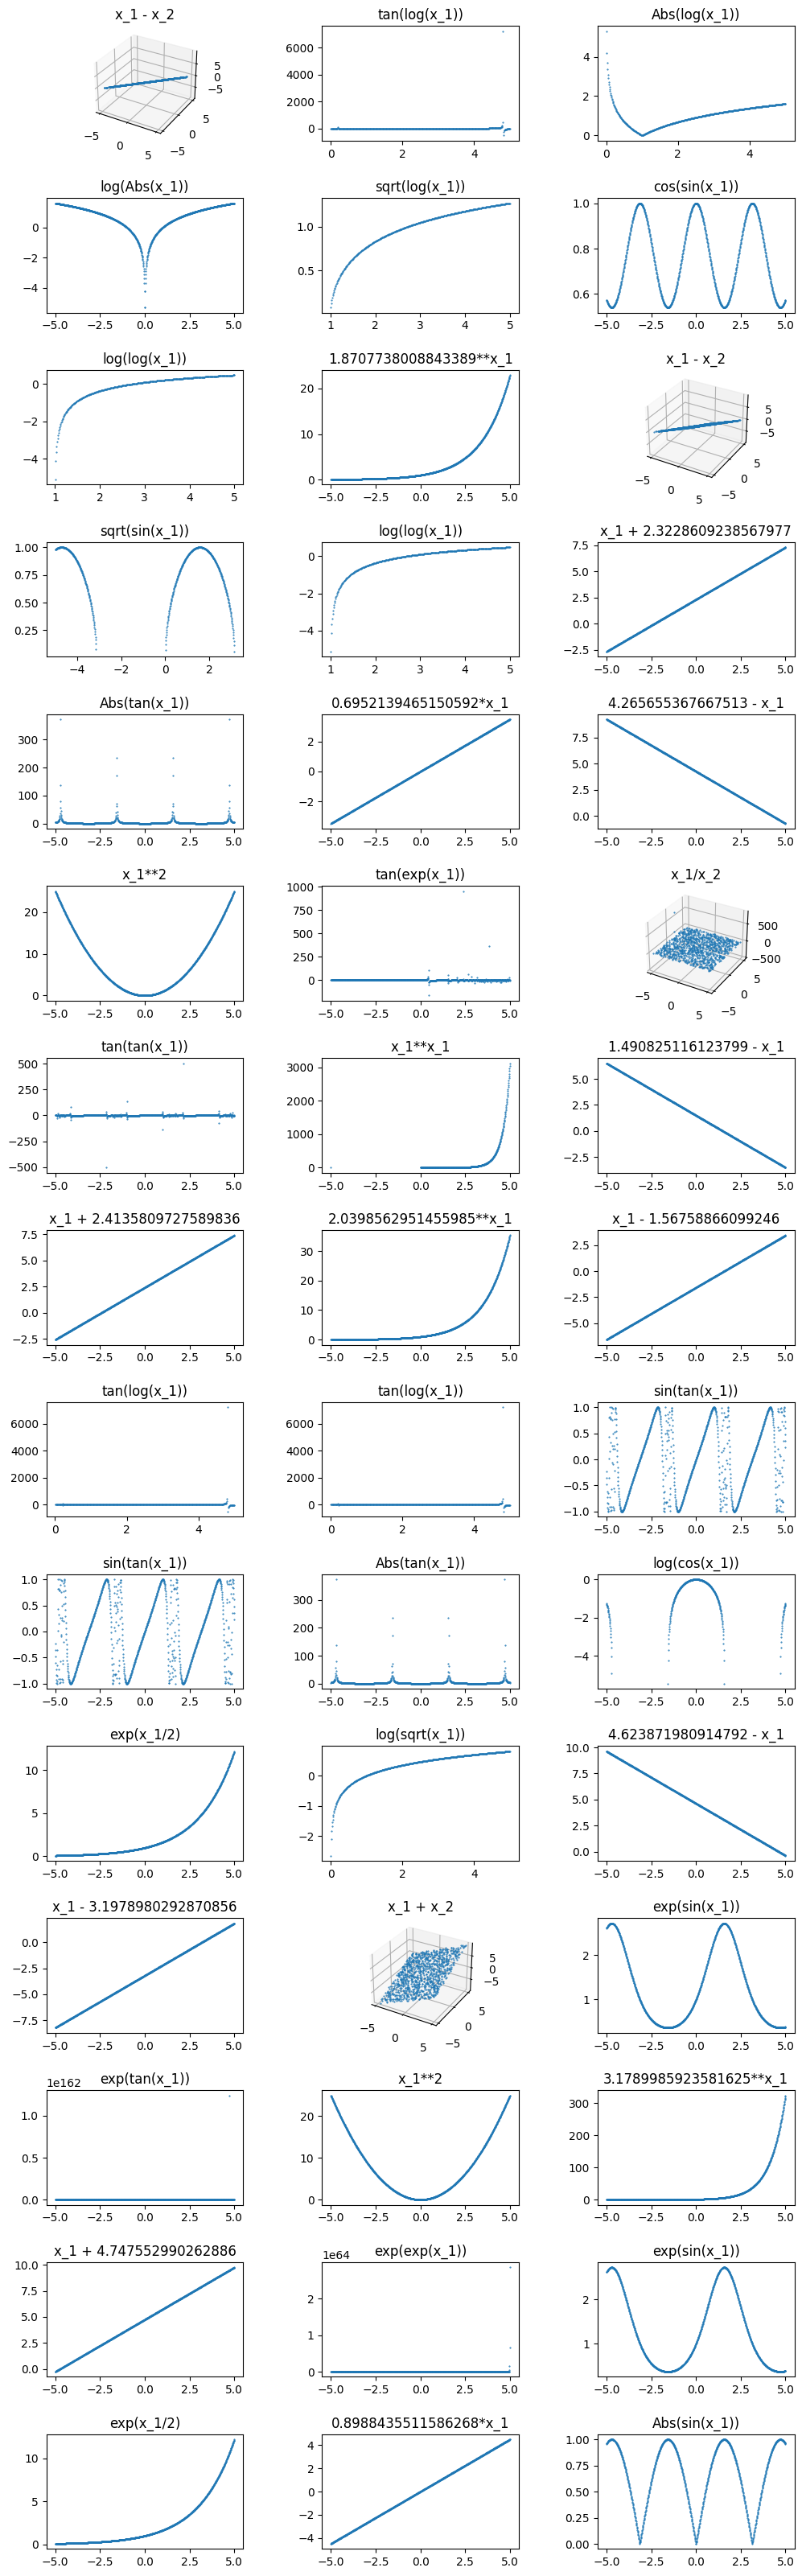

In [70]:
structure_prior = structure_prior_from_depth(3)
pprint.pprint(structure_prior)
pprint.pprint(DEFAULT_PRIOR_FUNCTIONS)
pprint.pprint(DEFAULT_PRIOR_OPERATORS)
feature_prior = {'constants': .3, 'variables': .7}
prior = {'functions': DEFAULT_PRIOR_FUNCTIONS, 'operators': DEFAULT_PRIOR_OPERATORS, 'structures': structure_prior, 'features': feature_prior}

sampled_equations = sample(n=45, prior=prior, max_num_variables=2)

fig = plt.figure(figsize=(12, 32))
fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)


for n in range(len(sampled_equations)):
    equation = sampled_equations[n]
    equation = instantiate_constants(equation, lambda: np.random.rand()*CONSTANT_SIZE)
    #print(equation.sympy_expr)
    features = {}
    for v in range(equation.n_variables_unique):
        array = np.linspace(-POOL_RANGE, POOL_RANGE, 1000)
        np.random.shuffle(array)
        features[equation.variables_unique[v]] = array
    
    variable_names = list(features.keys())        

    
    result = equation.evaluate(features)
    #plt.plot(features['x_1'],result.iloc[:], 'o')
    if len(variable_names) == 1:
        ax = fig.add_subplot(15,3,n+1)
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], result.iloc[:], '.', markersize=1)
    else: 
        ax = fig.add_subplot(15,3,n+1, projection='3d')
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], features[variable_names[1]], result.iloc[:], '.', markersize=1)

    
    #ax.plot3D(features['x_1'], features['x_2'], result.iloc[:], 'o', s=1)


{'[0, 1, 1, 2]': 0.25,
 '[0, 1, 2, 1]': 0.25,
 '[0, 1, 2, 2]': 0.25,
 '[0, 1, 2, 3]': 0.25}
{'abs': 0.14285714285714285,
 'cos': 0.14285714285714285,
 'exp': 0.14285714285714285,
 'log': 0.14285714285714285,
 'sin': 0.14285714285714285,
 'sqrt': 0.14285714285714285,
 'tan': 0.14285714285714285}
{'*': 0.2, '+': 0.2, '-': 0.2, '/': 0.2, '^': 0.2}


Processing: 100%|██████████| 45/45 [00:01<00:00, 34.02iteration/s]


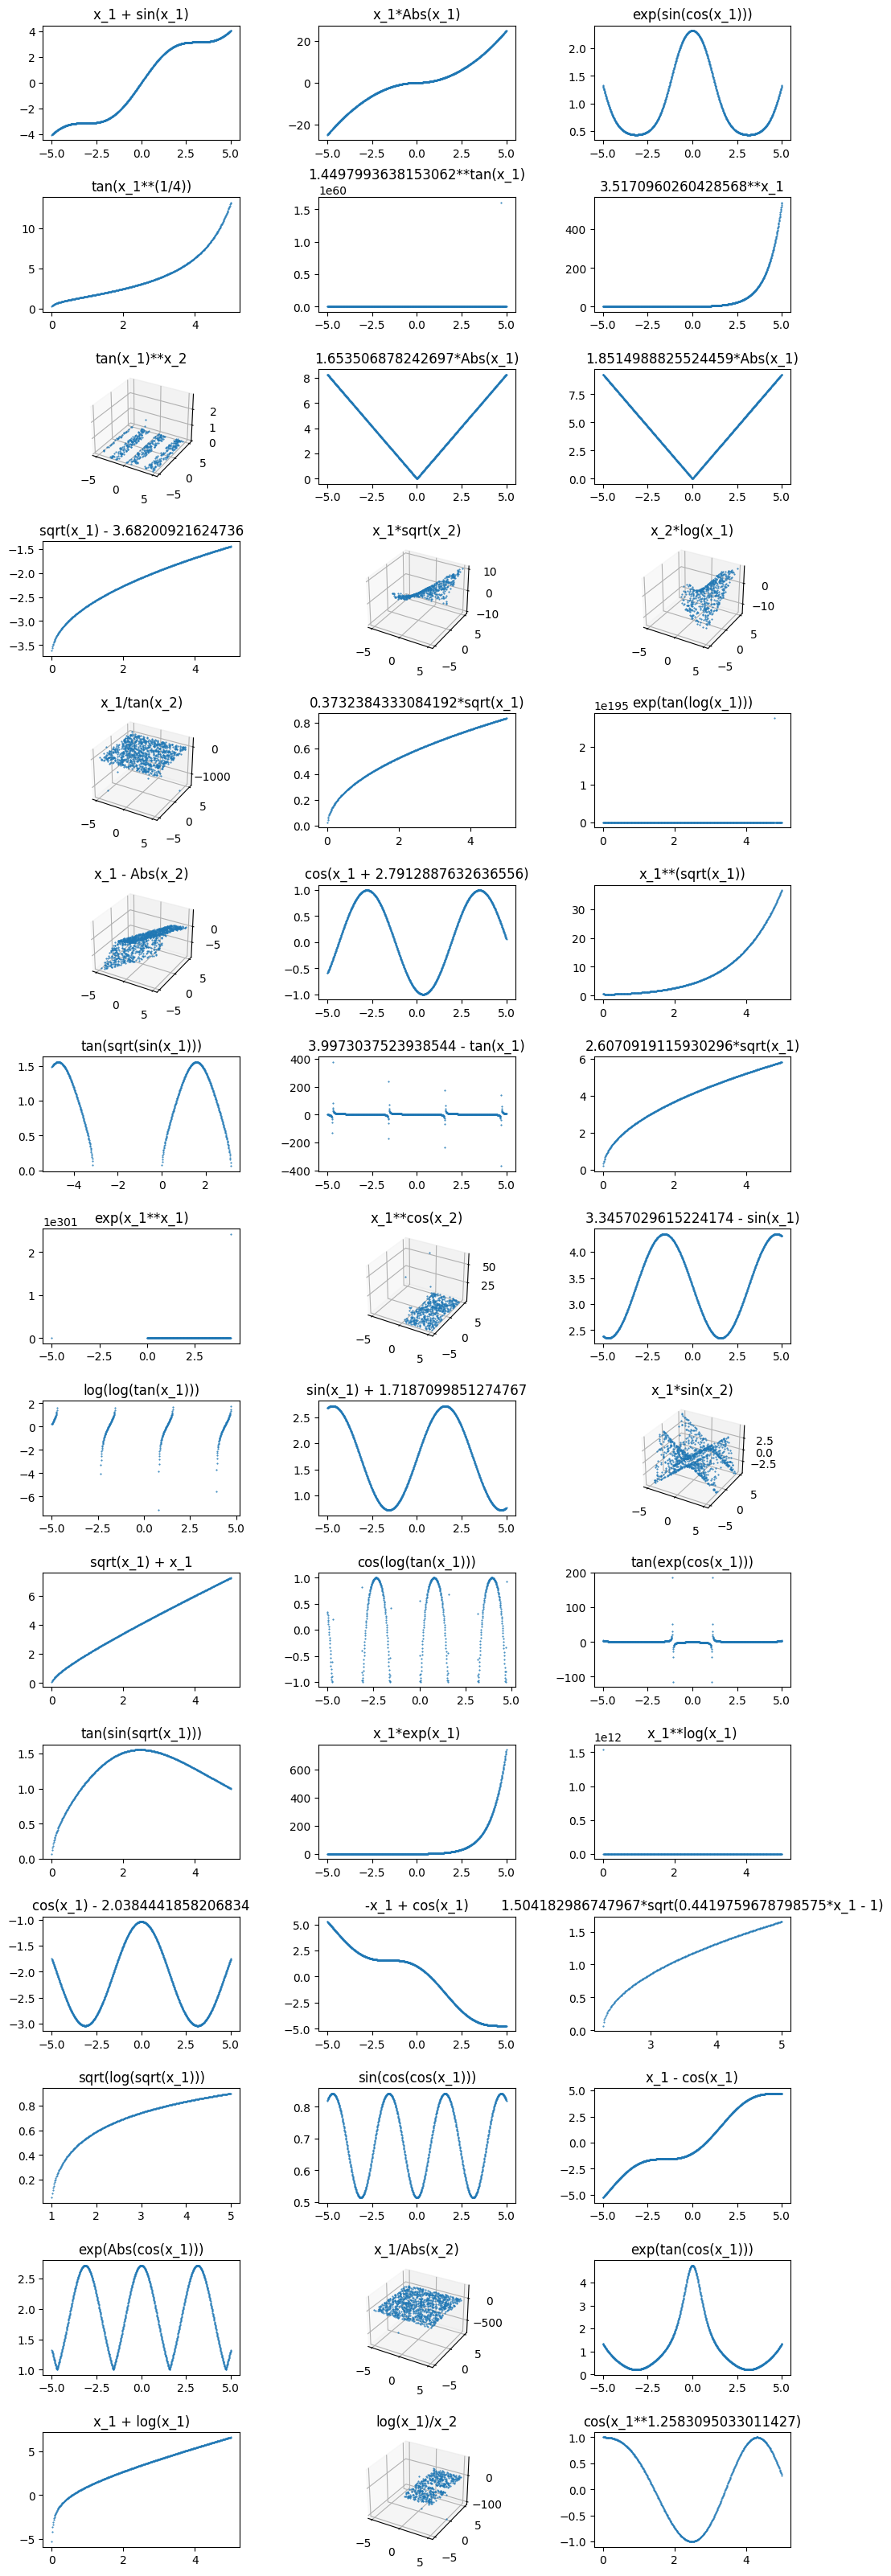

In [71]:
structure_prior = structure_prior_from_depth(4)
pprint.pprint(structure_prior)
pprint.pprint(DEFAULT_PRIOR_FUNCTIONS)
pprint.pprint(DEFAULT_PRIOR_OPERATORS)
feature_prior = {'constants': .3, 'variables': .7}
prior = {'functions': DEFAULT_PRIOR_FUNCTIONS, 'operators': DEFAULT_PRIOR_OPERATORS, 'structures': structure_prior, 'features': feature_prior}

sampled_equations = sample(n=45, prior=prior, max_num_variables=2)

fig = plt.figure(figsize=(12, 32))
fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)


for n in range(len(sampled_equations)):
    equation = sampled_equations[n]
    equation = instantiate_constants(equation, lambda: np.random.rand()*CONSTANT_SIZE)
    #print(equation.sympy_expr)
    features = {}
    for v in range(equation.n_variables_unique):
        array = np.linspace(-POOL_RANGE, POOL_RANGE, 1000)
        np.random.shuffle(array)
        features[equation.variables_unique[v]] = array
    
    variable_names = list(features.keys())        

    
    result = equation.evaluate(features)
    #plt.plot(features['x_1'],result.iloc[:], 'o')
    if len(variable_names) == 1:
        ax = fig.add_subplot(15,3,n+1)
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], result.iloc[:], '.', markersize=1)
    else: 
        ax = fig.add_subplot(15,3,n+1, projection='3d')
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], features[variable_names[1]], result.iloc[:], '.', markersize=1)

    
    #ax.plot3D(features['x_1'], features['x_2'], result.iloc[:], 'o', s=1)

{'[0, 1, 1, 2, 2]': 0.1111111111111111,
 '[0, 1, 1, 2, 3]': 0.1111111111111111,
 '[0, 1, 2, 1, 2]': 0.1111111111111111,
 '[0, 1, 2, 2, 1]': 0.1111111111111111,
 '[0, 1, 2, 2, 3]': 0.1111111111111111,
 '[0, 1, 2, 3, 1]': 0.1111111111111111,
 '[0, 1, 2, 3, 2]': 0.1111111111111111,
 '[0, 1, 2, 3, 3]': 0.1111111111111111,
 '[0, 1, 2, 3, 4]': 0.1111111111111111}
{'abs': 0.14285714285714285,
 'cos': 0.14285714285714285,
 'exp': 0.14285714285714285,
 'log': 0.14285714285714285,
 'sin': 0.14285714285714285,
 'sqrt': 0.14285714285714285,
 'tan': 0.14285714285714285}
{'*': 0.2, '+': 0.2, '-': 0.2, '/': 0.2, '^': 0.2}


Processing: 100%|██████████| 45/45 [00:01<00:00, 37.35iteration/s]


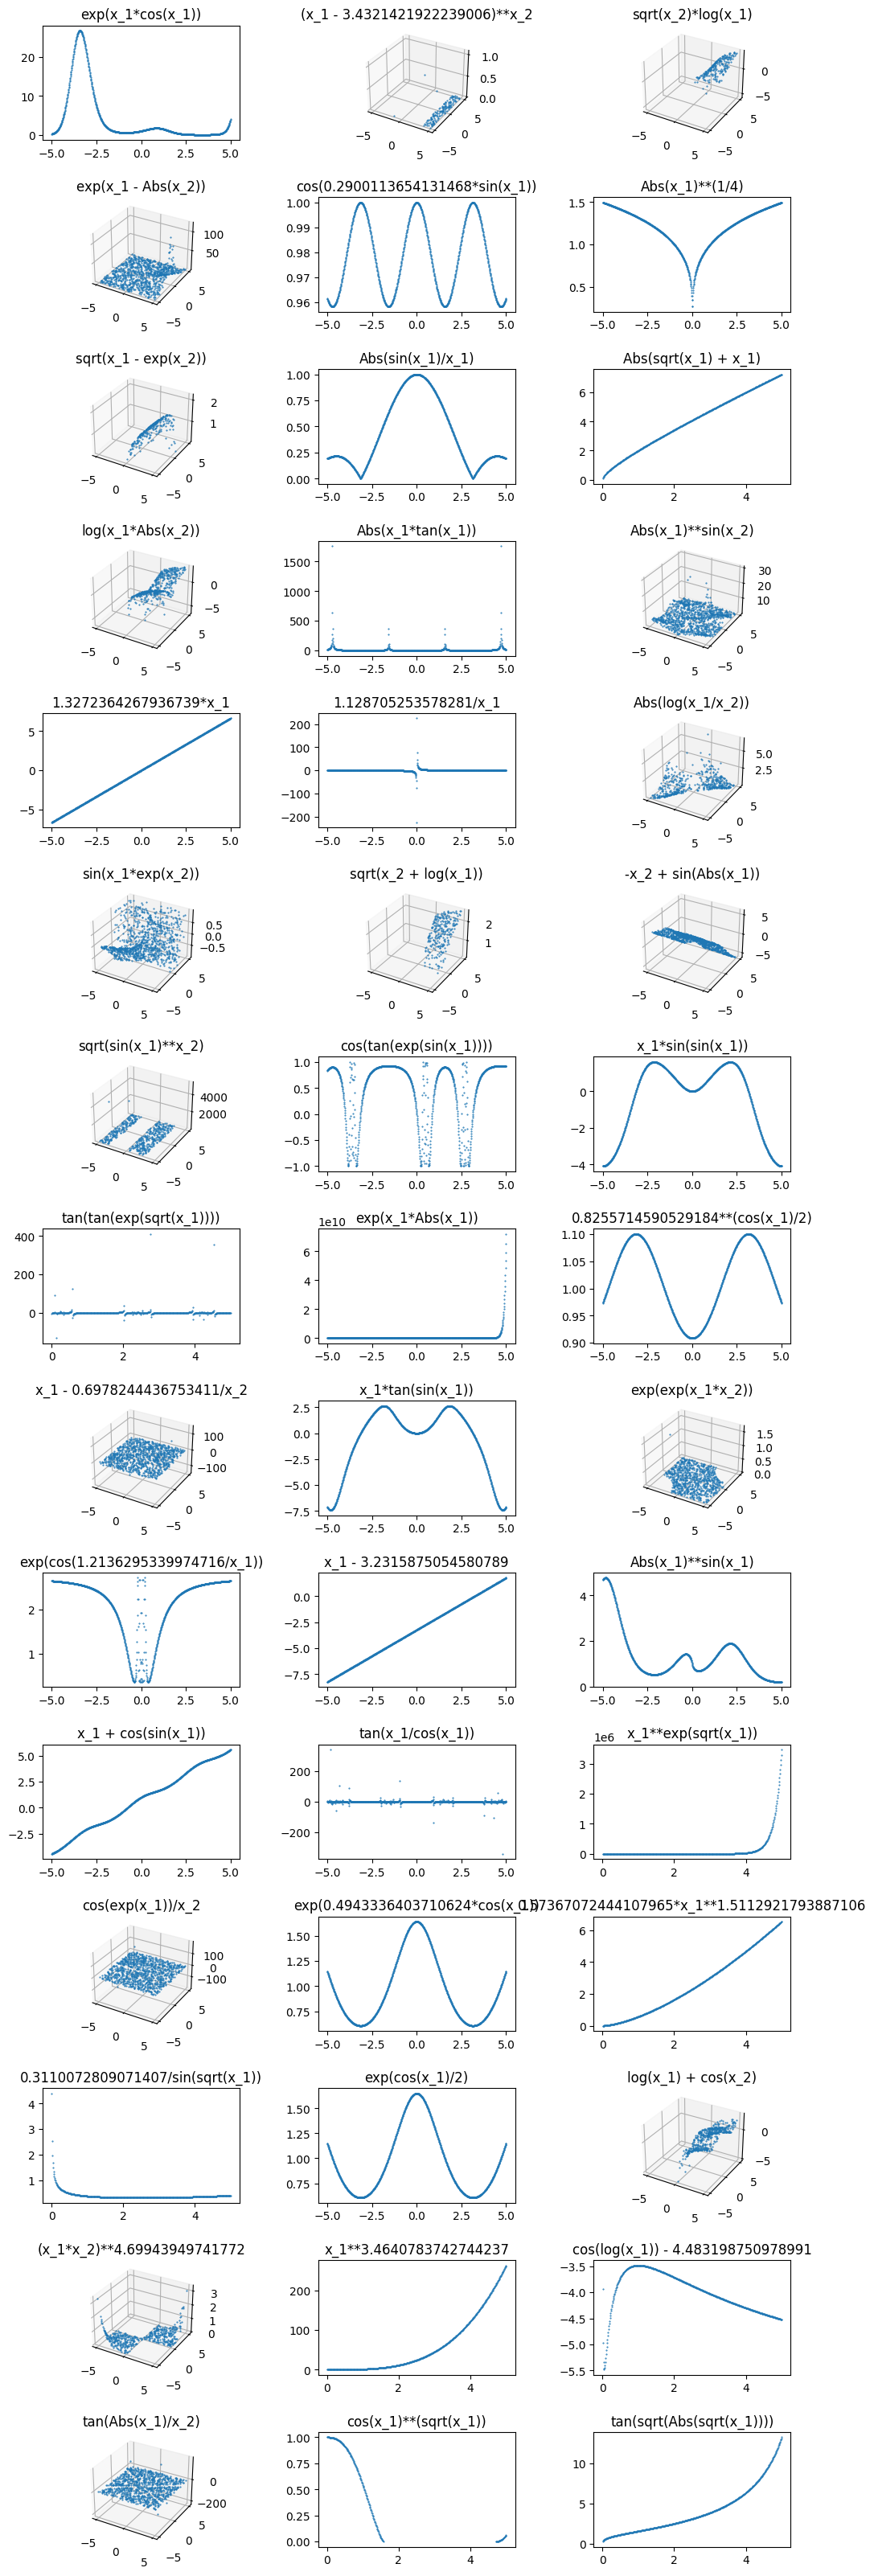

In [73]:
structure_prior = structure_prior_from_depth(5)
pprint.pprint(structure_prior)
pprint.pprint(DEFAULT_PRIOR_FUNCTIONS)
pprint.pprint(DEFAULT_PRIOR_OPERATORS)
feature_prior = {'constants': .3, 'variables': .7}
prior = {'functions': DEFAULT_PRIOR_FUNCTIONS, 'operators': DEFAULT_PRIOR_OPERATORS, 'structures': structure_prior, 'features': feature_prior}

sampled_equations = sample(n=45, prior=prior, max_num_variables=2)

fig = plt.figure(figsize=(12, 32))
fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)


for n in range(len(sampled_equations)):
    equation = sampled_equations[n]
    equation = instantiate_constants(equation, lambda: np.random.rand()*CONSTANT_SIZE)
    #print(equation.sympy_expr)
    features = {}
    for v in range(equation.n_variables_unique):
        array = np.linspace(-POOL_RANGE, POOL_RANGE, 1000)
        np.random.shuffle(array)
        features[equation.variables_unique[v]] = array
    
    variable_names = list(features.keys())        

    
    result = equation.evaluate(features)
    #plt.plot(features['x_1'],result.iloc[:], 'o')
    if len(variable_names) == 1:
        ax = fig.add_subplot(15,3,n+1)
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], result.iloc[:], '.', markersize=1)
    else: 
        ax = fig.add_subplot(15,3,n+1, projection='3d')
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], features[variable_names[1]], result.iloc[:], '.', markersize=1)

    
    #ax.plot3D(features['x_1'], features['x_2'], result.iloc[:], 'o', s=1)


{'[0, 1, 1, 2, 2, 3]': 0.047619047619047616,
 '[0, 1, 1, 2, 3, 2]': 0.047619047619047616,
 '[0, 1, 1, 2, 3, 3]': 0.047619047619047616,
 '[0, 1, 1, 2, 3, 4]': 0.047619047619047616,
 '[0, 1, 2, 1, 2, 2]': 0.047619047619047616,
 '[0, 1, 2, 1, 2, 3]': 0.047619047619047616,
 '[0, 1, 2, 2, 1, 2]': 0.047619047619047616,
 '[0, 1, 2, 2, 3, 1]': 0.047619047619047616,
 '[0, 1, 2, 2, 3, 3]': 0.047619047619047616,
 '[0, 1, 2, 2, 3, 4]': 0.047619047619047616,
 '[0, 1, 2, 3, 1, 2]': 0.047619047619047616,
 '[0, 1, 2, 3, 2, 1]': 0.047619047619047616,
 '[0, 1, 2, 3, 2, 3]': 0.047619047619047616,
 '[0, 1, 2, 3, 3, 1]': 0.047619047619047616,
 '[0, 1, 2, 3, 3, 2]': 0.047619047619047616,
 '[0, 1, 2, 3, 3, 4]': 0.047619047619047616,
 '[0, 1, 2, 3, 4, 1]': 0.047619047619047616,
 '[0, 1, 2, 3, 4, 2]': 0.047619047619047616,
 '[0, 1, 2, 3, 4, 3]': 0.047619047619047616,
 '[0, 1, 2, 3, 4, 4]': 0.047619047619047616,
 '[0, 1, 2, 3, 4, 5]': 0.047619047619047616}
{'abs': 0.14285714285714285,
 'cos': 0.1428571428571428

Processing: 100%|██████████| 45/45 [00:02<00:00, 17.10iteration/s]


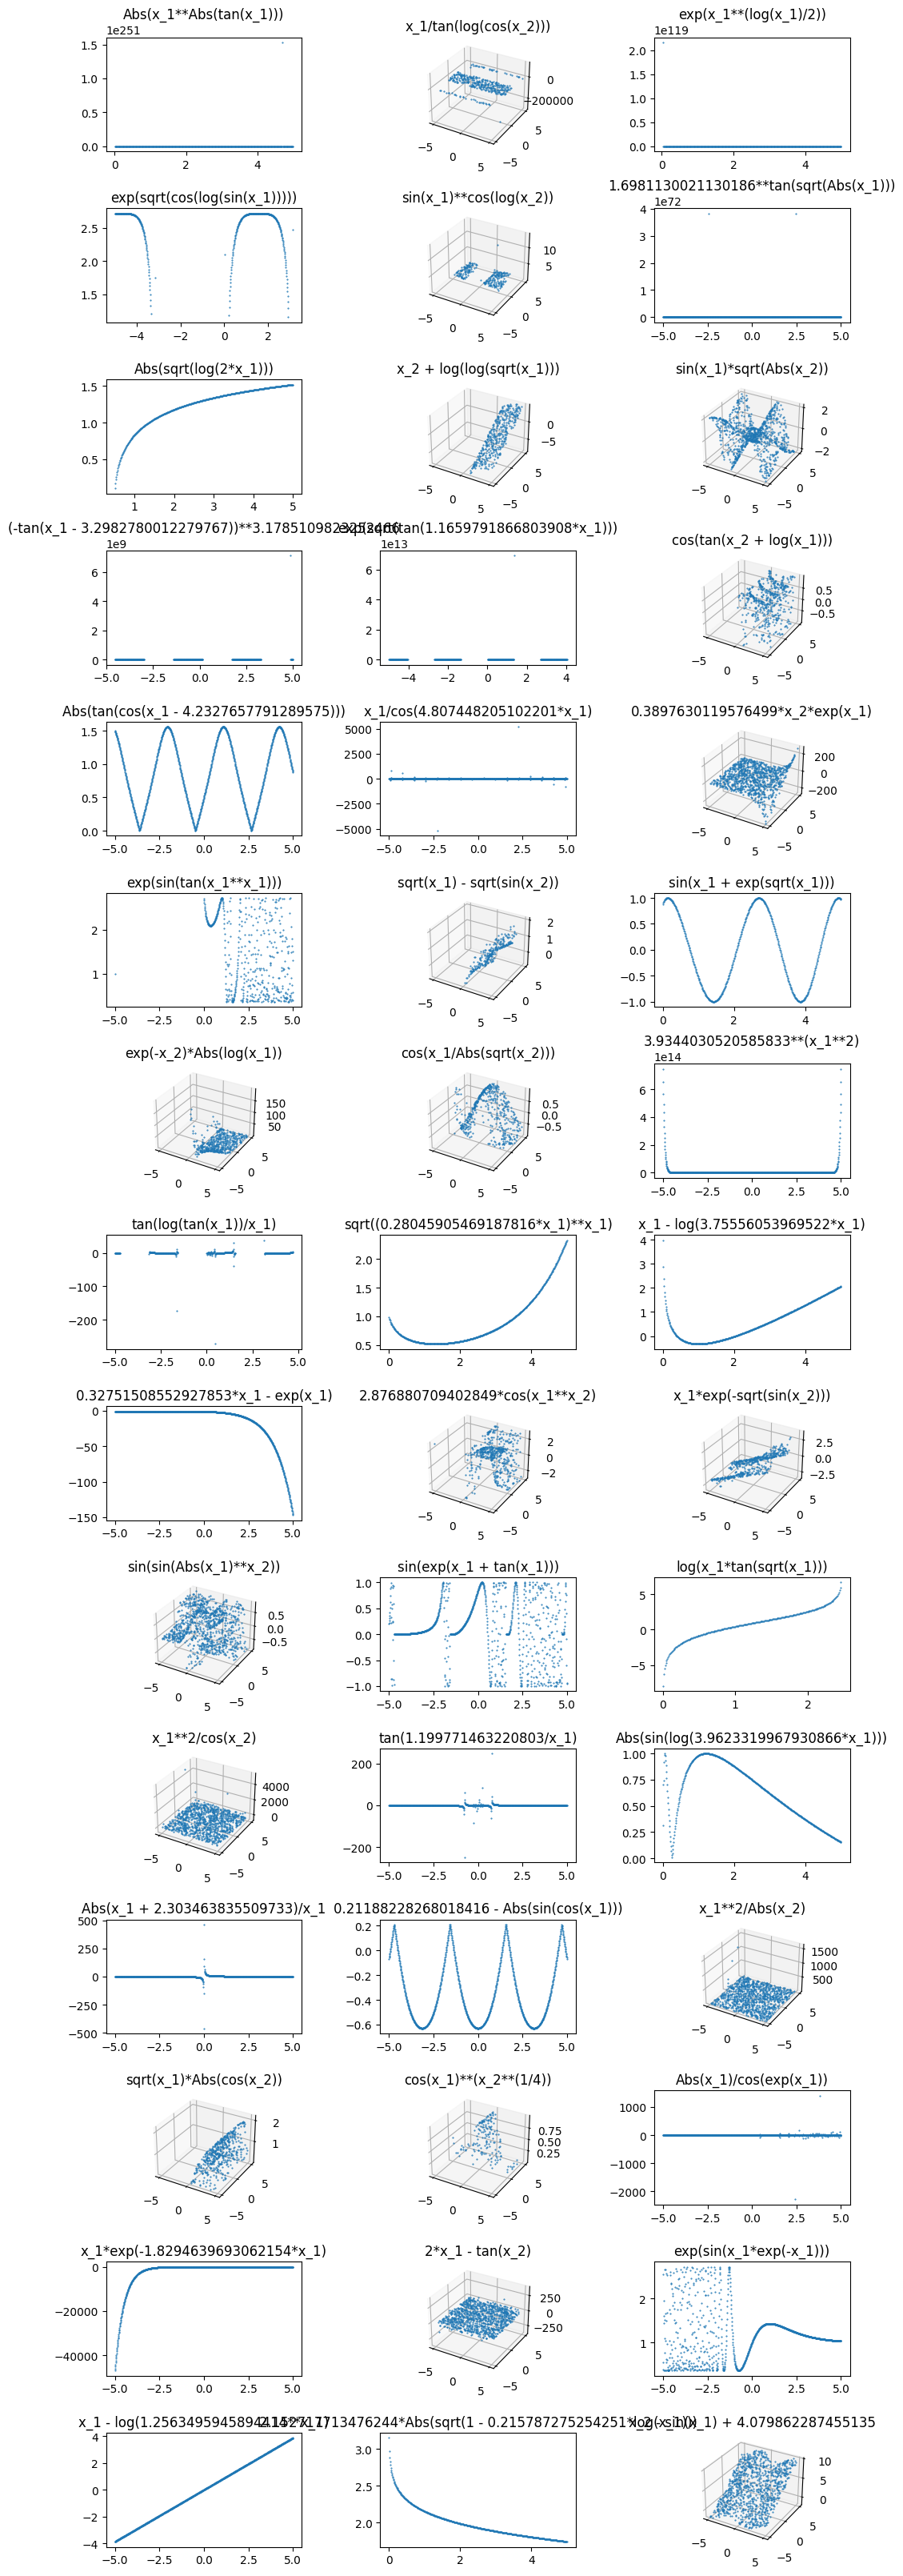

In [74]:
structure_prior = structure_prior_from_depth(6)
pprint.pprint(structure_prior)
pprint.pprint(DEFAULT_PRIOR_FUNCTIONS)
pprint.pprint(DEFAULT_PRIOR_OPERATORS)
feature_prior = {'constants': .3, 'variables': .7}
prior = {'functions': DEFAULT_PRIOR_FUNCTIONS, 'operators': DEFAULT_PRIOR_OPERATORS, 'structures': structure_prior, 'features': feature_prior}

sampled_equations = sample(n=45, prior=prior, max_num_variables=2)

fig = plt.figure(figsize=(12, 32))
fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)


for n in range(len(sampled_equations)):
    equation = sampled_equations[n]
    equation = instantiate_constants(equation, lambda: np.random.rand()*CONSTANT_SIZE)
    #print(equation.sympy_expr)
    features = {}
    for v in range(equation.n_variables_unique):
        array = np.linspace(-POOL_RANGE, POOL_RANGE, 1000)
        np.random.shuffle(array)
        features[equation.variables_unique[v]] = array
    
    variable_names = list(features.keys())        

    
    result = equation.evaluate(features)
    #plt.plot(features['x_1'],result.iloc[:], 'o')
    if len(variable_names) == 1:
        ax = fig.add_subplot(15,3,n+1)
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], result.iloc[:], '.', markersize=1)
    else: 
        ax = fig.add_subplot(15,3,n+1, projection='3d')
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], features[variable_names[1]], result.iloc[:], '.', markersize=1)


{'[0, 1, 1, 2, 2, 3, 3]': 0.0196078431372549,
 '[0, 1, 1, 2, 2, 3, 4]': 0.0196078431372549,
 '[0, 1, 1, 2, 3, 2, 3]': 0.0196078431372549,
 '[0, 1, 1, 2, 3, 3, 2]': 0.0196078431372549,
 '[0, 1, 1, 2, 3, 3, 4]': 0.0196078431372549,
 '[0, 1, 1, 2, 3, 4, 2]': 0.0196078431372549,
 '[0, 1, 1, 2, 3, 4, 3]': 0.0196078431372549,
 '[0, 1, 1, 2, 3, 4, 4]': 0.0196078431372549,
 '[0, 1, 1, 2, 3, 4, 5]': 0.0196078431372549,
 '[0, 1, 2, 1, 2, 2, 3]': 0.0196078431372549,
 '[0, 1, 2, 1, 2, 3, 2]': 0.0196078431372549,
 '[0, 1, 2, 1, 2, 3, 3]': 0.0196078431372549,
 '[0, 1, 2, 1, 2, 3, 4]': 0.0196078431372549,
 '[0, 1, 2, 2, 1, 2, 2]': 0.0196078431372549,
 '[0, 1, 2, 2, 1, 2, 3]': 0.0196078431372549,
 '[0, 1, 2, 2, 3, 1, 2]': 0.0196078431372549,
 '[0, 1, 2, 2, 3, 3, 1]': 0.0196078431372549,
 '[0, 1, 2, 2, 3, 3, 4]': 0.0196078431372549,
 '[0, 1, 2, 2, 3, 4, 1]': 0.0196078431372549,
 '[0, 1, 2, 2, 3, 4, 3]': 0.0196078431372549,
 '[0, 1, 2, 2, 3, 4, 4]': 0.0196078431372549,
 '[0, 1, 2, 2, 3, 4, 5]': 0.019607

Processing: 100%|██████████| 45/45 [00:04<00:00,  9.06iteration/s]


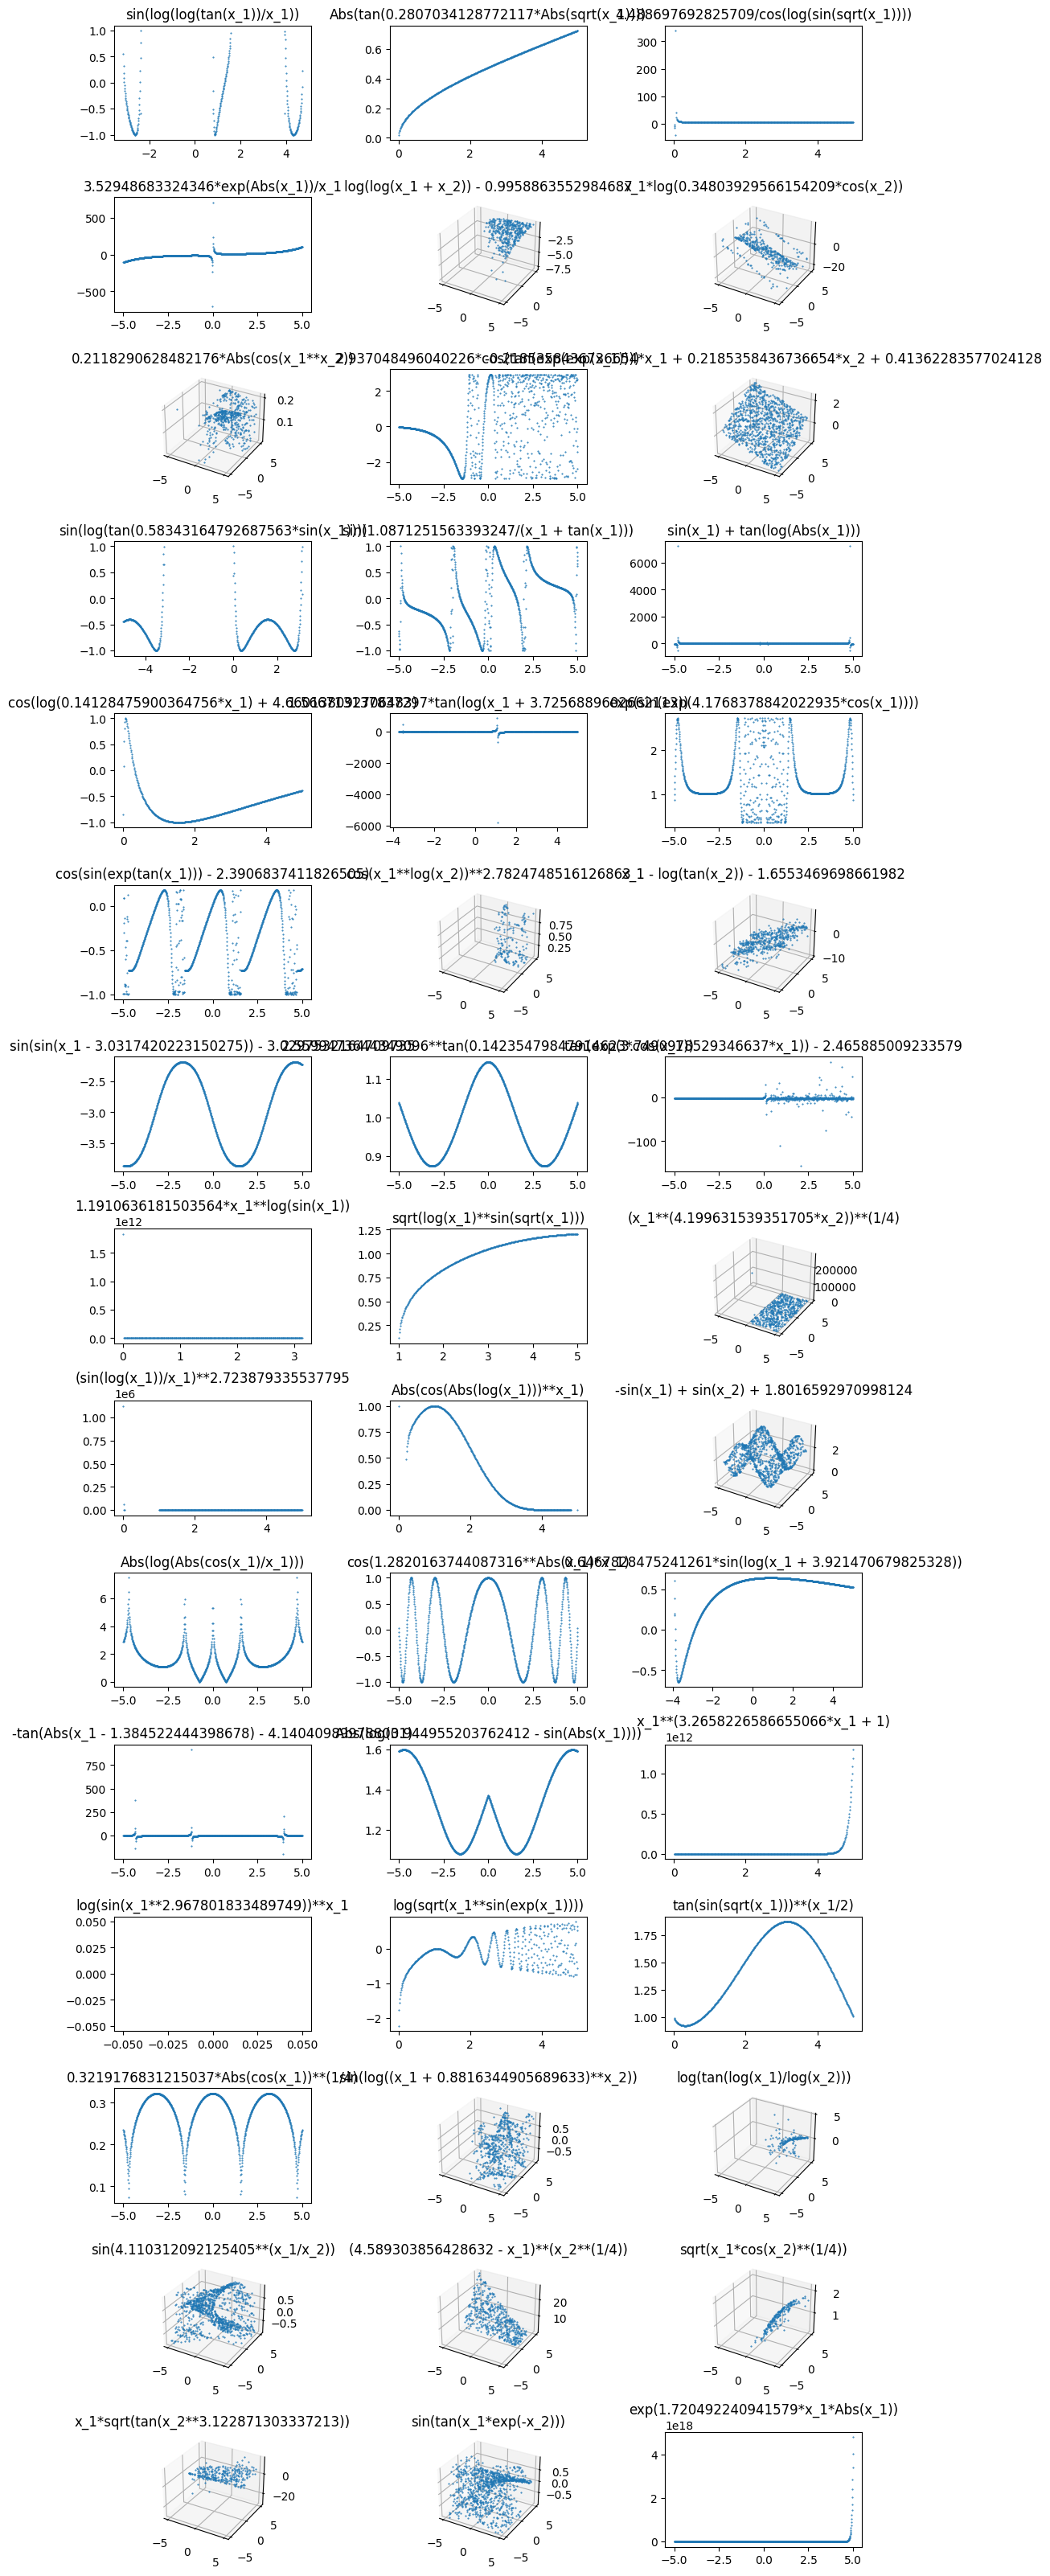

In [75]:
structure_prior = structure_prior_from_depth(7)
pprint.pprint(structure_prior)
pprint.pprint(DEFAULT_PRIOR_FUNCTIONS)
pprint.pprint(DEFAULT_PRIOR_OPERATORS)
feature_prior = {'constants': .3, 'variables': .7}
prior = {'functions': DEFAULT_PRIOR_FUNCTIONS, 'operators': DEFAULT_PRIOR_OPERATORS, 'structures': structure_prior, 'features': feature_prior}

sampled_equations = sample(n=45, prior=prior, max_num_variables=2)

fig = plt.figure(figsize=(12, 32))
fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)


for n in range(len(sampled_equations)):
    equation = sampled_equations[n]
    equation = instantiate_constants(equation, lambda: np.random.rand()*CONSTANT_SIZE)
    #print(equation.sympy_expr)
    features = {}
    for v in range(equation.n_variables_unique):
        array = np.linspace(-POOL_RANGE, POOL_RANGE, 1000)
        np.random.shuffle(array)
        features[equation.variables_unique[v]] = array
    
    variable_names = list(features.keys())        

    
    result = equation.evaluate(features)
    #plt.plot(features['x_1'],result.iloc[:], 'o')
    if len(variable_names) == 1:
        ax = fig.add_subplot(15,3,n+1)
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], result.iloc[:], '.', markersize=1)
    else: 
        ax = fig.add_subplot(15,3,n+1, projection='3d')
        ax.set_title(equation.sympy_expr)
        ax.plot(features[variable_names[0]], features[variable_names[1]], result.iloc[:], '.', markersize=1)


Defining the metadata based on the sampled ground truth.

In [407]:
independent_variables = []
for v in range(equation.n_variables_unique):
    independent_variables.append(Variable(equation.variables_unique[v],value_range=(-POOL_RANGE, POOL_RANGE)))

variables=VariableCollection(
        independent_variables=independent_variables,
        dependent_variables=[Variable("y")]
    )

Defining experiment runner from the equation and the variable collection

In [408]:
experiment = equation_experiment(equation.sympy_expr, variables.independent_variables, variables.dependent_variables[0], rename_output_columns=False)

### Defining the state
We can define an initial state for our discovery problem based on the variable specification above. Wrapping experiment runner into the state.

In [409]:
@dataclass(frozen=True)
class ExtendedState(StandardState):
    models_bms: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_linear: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_polynom: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    rejections: List[int] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    mad: List[float] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )

state = ExtendedState(
    variables=variables
)
runner_on_state = on_state(experiment.experiment_runner, output=["experiment_data"])

### Pooler

In [410]:
@on_state()
def experimentalist_pooler(variables, equation):
    conditions_ = pd.DataFrame(columns=[v.name for v in variables.independent_variables])
    i = 0
    n = 0
    while i < 1_000_000 and len(conditions_.index) < NUM_POOL_SAMPLES:
        _sample = random_pool(variables, NUM_POOL_SAMPLES)
        n += NUM_POOL_SAMPLES
        evaluation = equation.evaluate(_sample)
        bad_indices = np.where(np.isnan(evaluation) | np.isinf(evaluation))[0]
        _sample = _sample.drop(bad_indices)
        if np.isnan(evaluation).any() or np.isinf(evaluation).any():
            i+=len(bad_indices)
        conditions_ = pd.concat([conditions_,_sample], ignore_index=True)
    if i >= 1_000_000:
        return None
    conditions_ = conditions_.head(NUM_POOL_SAMPLES)
    return Delta(conditions=conditions_, rejections=[i/n])

## Mixture experimentalist
Defining the mixture experimentalist and wrapping it into the state

In [411]:
"""
Mixture Experimentalist Sampler
"""

import numpy as np
from typing import Optional, Union

import pandas as pd


def adjust_distribution(p_, temperature):
    # temperature cannot be 0
    assert temperature != 0, 'Temperature cannot be 0'
    p = np.array(p_)
    # If the temperature is very low (close to 0), then the sampling will become almost deterministic, picking the event with the highest probability.
    # If the temperature is very high, then the sampling will be closer to uniform, with all events having roughly equal probability.

    p = p / np.sum(np.abs(p))  # Normalizing the initial distribution

    p = np.exp(p / temperature)
    final_p = p / np.sum(p)  # Normalizing the final distribution
    return final_p


def sample(conditions: Union[pd.DataFrame, np.ndarray], temperature: float,
                   samplers: list, params: dict,
                   num_samples: Optional[int] = None) -> pd.DataFrame:
    """

    Args:
        conditions: pool of experimental conditions to evaluate: pd.Dataframe
        temperature: how random is selection of conditions (cannot be 0; (0:1) - the choices are more deterministic than the choices made wrt
        samplers: tuple containing sampler functions, their names, and weights
        for sampler functions that return both positive and negative scores, user can provide a list with two weights: the first one will be applied to positive scores, the second one -- to the negative
        params: nested dictionary. keys correspond to the sampler function names (same as provided in samplers),
        values correspond to the dictionaries of function arguments (argument name: its value)
        num_samples: number of experimental conditions to select

    Returns:
        Sampled pool of experimental conditions with the scores attached to them
    """

    condition_pool = pd.DataFrame(conditions)

    rankings = pd.DataFrame()
    mixture_scores = np.zeros(len(condition_pool))
    ## getting rankings and weighted scores from each function
    for (function, name, weight) in samplers:

        sampler_params = params[name]
        pd_ranking = function(conditions=condition_pool, **sampler_params)

        # except:
        #     pd_ranking = function(conditions=condition_pool)
        # sorting by index
        pd_ranking = pd_ranking.sort_index()
        # if only one weight is provided, use it for both negative and positive dimensions
        if isinstance(weight, float) or isinstance(weight, int):
            pd_ranking["score"] = pd_ranking["score"] * weight
        else:
            if len(pd_ranking["score"] < 0) > 0 and len(pd_ranking["score"] > 0) > 0:  # there are both positive and negative values
                pd_ranking.loc[pd_ranking["score"] > 0]["score"] = pd_ranking.loc[pd_ranking["score"] > 0]["score"] * weight[0]  # positive dimension gets the first weight
                pd_ranking.loc[pd_ranking["score"] < 0]["score"] = pd_ranking.loc[pd_ranking["score"] < 0]["score"] * weight[1]  # negative dimension gets the second weight
            else:
                pd_ranking["score"] = pd_ranking["score"] * weight[0]

        pd_ranking.rename(columns={"score": f"{name}_score"}, inplace=True)
        # sum_scores are arranged based on the original conditions_ indices
        mixture_scores = mixture_scores + pd_ranking[f"{name}_score"]

        rankings = pd.merge(rankings, pd_ranking, left_index=True, right_index=True, how="outer")

    # adjust mixture scores wrt temperature
    weighted_mixture_scores_adjusted = adjust_distribution(mixture_scores, temperature)

    if num_samples is None:
        num_samples = condition_pool.shape[0]

    condition_indices = np.random.choice(np.arange(len(condition_pool)), num_samples,
                                         p=weighted_mixture_scores_adjusted, replace=False)
    conditions_ = condition_pool.iloc[condition_indices]
    conditions_["score"] = mixture_scores

    return conditions_


mixture_sample_test = sample

In [412]:
def get_best_model(models, X, y):
    mads = []
    for m in models:
        prediction = m.predict(X)
        mad = mean_absolute_error(y, prediction)
        mads.append(mad)
    min_value = min(mads)
    min_index = mads.index(min_value)
    mads[min_index] = math.inf
    min_value_second = min(mads)
    min_index_second = mads.index(min_value_second)
    return models[min_index], models[min_index_second], min_value


In [425]:
@on_state()
def experimentalist_sample(conditions,
                           models,
                           models_bms,
                           models_linear,
                           models_polynom,
                           experiment_data,
                           variables,
                           temperature,
                           weights,
                           num_samples):
    if models is None or experiment_data is None:
        print('First cycle: Using random sampler')
        conditions_ = random_sample(conditions, num_samples)
        mad = None
    else:
        experiment_conditions = experiment_data[[v.name for v in variables.independent_variables]]
        experiment_observations = experiment_data[[v.name for v in variables.dependent_variables]]
        params_ = {} #copy.deepcopy(params)
        params_["falsification"] = {"reference_conditions": experiment_conditions, "reference_observations": experiment_observations, "model": models[-1]}

        params_["novelty"] = {"reference_conditions": experiment_conditions}
        second_bms_model = models_bms[-1].get_models()[1]
        models_to_consider = [models_bms[-1], second_bms_model, models_linear[-1], models_polynom[-1]]
        best_model, second_best_model, mad = get_best_model(models_to_consider, experiment_conditions, experiment_observations)

        params_["disagreement"] = {"models": [best_model, second_best_model], "num_samples": NUM_POOL_SAMPLES}

        samplers = [
            [novelty_score_sample, "novelty", weights["novelty"]],
            [falsification_score_sample, "falsification", weights["falsification"]],
            [model_disagreement_score_sample, "disagreement", weights["disagreement"]]
        ]

        conditions_ = mixture_sample_test(conditions, temperature, samplers, params_, num_samples)
        conditions_ = conditions_.drop("score", axis = 1)
    #d = Delta(conditions=conditions)
    d = Delta(conditions = conditions_, mads=[mad])
    return d

## BMS theorist
Defining the BMS theorist and wrapping it into the state

In [426]:
@on_state()
def bms_theorist(experiment_data: pd.DataFrame, variables: VariableCollection, **kwargs):
    ivs = [v.name for v in variables.independent_variables]
    dvs = [v.name for v in variables.dependent_variables]
    X, y = experiment_data[ivs], experiment_data[dvs]
    new_model = BMSRegressor(epochs=EPOCHS).set_params(**kwargs).fit(X, y)
    return Delta(models_bms=[new_model])

@on_state()
def linear_theorist(experiment_data: pd.DataFrame, variables: VariableCollection, **kwargs):
    ivs = [v.name for v in variables.independent_variables]
    dvs = [v.name for v in variables.dependent_variables]
    X, y = experiment_data[ivs], experiment_data[dvs]
    new_model = LinearRegression().set_params(**kwargs).fit(X, y)
    return Delta(models_linear=[new_model])


def PolynomialRegression(degree=3, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))


@on_state()
def polynomial_theorist(experiment_data: pd.DataFrame, variables: VariableCollection, **kwargs):
    ivs = [v.name for v in variables.independent_variables]
    dvs = [v.name for v in variables.dependent_variables]
    X, y = experiment_data[ivs], experiment_data[dvs]
    new_model = PolynomialRegression()
    new_model.fit(X, y)
    return Delta(models_polynom=[new_model])


In [427]:
@on_state()
def best_model(models_bms, models_linear, models_polynom, experiment_data, variables):
    ivs = [v.name for v in variables.independent_variables]
    dvs = [v.name for v in variables.dependent_variables]
    X, y = experiment_data[ivs], experiment_data[dvs]
    prediction_bms = models_bms[-1].predict(X)
    prediction_linear = models_linear[-1].predict(X)
    prediction_polynomial = models_polynom[-1].predict(X)
    mad_bms = mean_absolute_error(y, prediction_bms)
    mad_linear = mean_absolute_error(y, prediction_linear)
    mad_poly = mean_absolute_error(y, prediction_polynomial)
    if mad_bms <= mad_linear and mad_bms <= mad_poly:
        new_model = models_bms[-1]
    elif mad_linear <= mad_bms and mad_linear <= mad_poly:
        new_model = models_linear[-1]
    elif mad_poly <= mad_linear and mad_poly <= mad_bms:
        new_model = models_polynom[-1]

    return Delta(model=new_model)


In [428]:
def cycle(s):
    s_pool = experimentalist_pooler(s, equation=equation)

    s_conditions = experimentalist_sample(s_pool, temperature=TEMPERATURE, weights=WEIGHTS, num_samples=NUM_SAMPLES)
    s_run = runner_on_state(s_conditions, added_noise = ADDED_NOISE)
    s_theory = bms_theorist(s_run)
    s_theory = linear_theorist(s_theory)
    s_theory = polynomial_theorist(s_theory)
    s_best = best_model(s_theory)
    return s_best


In [429]:
state = ExtendedState(variables=variables)
for _ in range(CYCLES):
    state = cycle(state)
    print(state)


INFO:autora.theorist.bms.regressor:BMS fitting started


First cycle: Using random sampler


100%|██████████| 100/100 [00:02<00:00, 42.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


ExtendedState(variables=VariableCollection(independent_variables=[Variable(name='x_1', value_range=(-5, 5), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False), Variable(name='x_2', value_range=(-5, 5), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=           x_1       x_2
6628  1.377312 -4.123979
2656 -2.985416 -0.450474
6685  0.968090  3.185195
7333 -1.210601 -1.623411
2235 -4.055146 -0.610022
...        ...       ...
4933 -4.416278 -0.169050
3589 -2.516866 -1.794918
1278 -0.143549  2.845302
1174 -2.716998 -1.652467
8241  2.363414  1.763106

[100 rows x 2 columns], experiment_data=           x_1       x_2         y
6628  1.377312 -4.123979 -4.044311
2656 -2.98541

AttributeError: 'BMSRegressor' object has no attribute 'get_models'